# Convolutional Neural Networks

## Objective is to get an app that works in 2 steps:
1. classify image in 1 of 3 categories
- human, dog, neither;
2. in case of human or dog classify image to dog breeds category.

In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline    

## Datasets

[dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

[human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)

In [ ]:
import numpy as np
from glob import glob

human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


Number of faces detected: 1


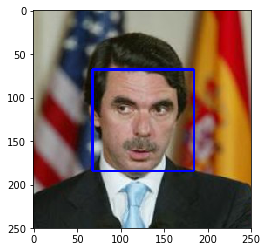

In [ ]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[355])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [ ]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

total_images = len(human_files_short)
face_detected_qnt = 0
for img_path in tqdm(human_files_short):
        face_detected_qnt += face_detector(img_path)
print('Human faces detected in human_files_short: ' + str(face_detected_qnt/total_images * 100) + '%')

total_images = len(dog_files_short)
face_detected_qnt = 0
for img_path in tqdm(dog_files_short):
        face_detected_qnt += face_detector(img_path)
print('Human faces detected in dog_files_short: ' + str(face_detected_qnt/total_images * 100) + '%')

  0%|          | 0/100 [00:00<?, ?it/s]

Human faces detected in human_files_short: 98.0%


100%|██████████| 100/100 [01:20<00:00,  3.93it/s]

Human faces detected in dog_files_short: 17.0%


In [ ]:
# Pre-trained VGG-16 Model

import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 121792737.00it/s]


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

VGG16.eval()
imgsize = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((imgsize,imgsize)),
                                transforms.ToTensor(),
                                normalize])

def VGG16_predict(img_path):
    
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze(0)
    output = VGG16(image)
    pr_class = int(torch.max(output,1)[1])
    
    return pr_class # predicted class index

In [ ]:
### returns "True" for dog
def dog_detector(img_path):
    VGG16_pr_class = VGG16_predict(img_path)
    if VGG16_pr_class > 150 and VGG16_pr_class < 267:
        is_dog = True
    else:
        is_dog = False
    return is_dog # true/false

In [ ]:
total_images = len(human_files_short)
dog_detected_qnt = 0
for img_path in tqdm(human_files_short):
        dog_detected_qnt += dog_detector(img_path)
print('Dogs detected in human_files_short: ' + str(dog_detected_qnt/total_images * 100) + '%')

total_images = len(dog_files_short)
dog_detected_qnt = 0
for img_path in tqdm(dog_files_short):
        dog_detected_qnt += dog_detector(img_path)
print('Dogs detected in dog_files_short: ' + str(dog_detected_qnt/total_images * 100) + '%')

  0%|          | 0/100 [00:00<?, ?it/s]

Dogs detected in human_files_short: 0.0%


100%|██████████| 100/100 [01:17<00:00,  1.31it/s]

Dogs detected in dog_files_short: 100.0%


# Dog breed classification

In [ ]:
import os
import numpy as np
from glob import glob
import torch
from torchvision import datasets, transforms

#data_dir = glob("/data/dog_images/")
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

normalization = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

data_transform = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      normalization]),
                  'valid': transforms.Compose([transforms.Resize((256)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalization]),
                  'test': transforms.Compose([transforms.Resize((256)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalization])}

train_data = datasets.ImageFolder(train_dir, transform=data_transform['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transform['test'])

# dataset size
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))


batch_size = 20
num_workers=0

loaders_transfer = {'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True),
                   'valid':  torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False),
                   'test': torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)}

Num training images:  6680
Num validation images:  835
Num test images:  836


# CNN using Transfer Learning

In [ ]:
import torchvision.models as models
import torch.nn as nn

from PIL import ImageFile                #
ImageFile.LOAD_TRUNCATED_IMAGES = True   #fix for problem:   OSError: image file is truncated (150 bytes not processed)

use_cuda = torch.cuda.is_available()

model_transfer = models.vgg16(pretrained=True)         #loading pretrained VGG16

for param in model_transfer.features.parameters():     #freezing weight for features layers
    param.requires_grad = False
    
n_classes = 133
model_transfer.classifier[6] = nn.Linear(in_features=4096, out_features=n_classes, bias=True)      #replacing final layer of classifier


if use_cuda:
    model_transfer = model_transfer.cuda()

In [ ]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
n_epochs = 3
#model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

0 train batch finished
1 train batch finished
2 train batch finished
3 train batch finished
4 train batch finished
5 train batch finished
6 train batch finished
7 train batch finished
8 train batch finished
9 train batch finished
10 train batch finished
11 train batch finished
12 train batch finished
13 train batch finished
14 train batch finished
15 train batch finished
16 train batch finished
17 train batch finished
18 train batch finished
19 train batch finished
20 train batch finished
21 train batch finished
22 train batch finished
23 train batch finished
24 train batch finished
25 train batch finished
26 train batch finished
27 train batch finished
28 train batch finished
29 train batch finished
30 train batch finished
31 train batch finished
32 train batch finished
33 train batch finished
34 train batch finished
35 train batch finished
36 train batch finished
37 train batch finished
38 train batch finished
39 train batch finished
40 train batch finished
41 train batch finished
42

### Test

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

0 test batch finished
1 test batch finished
2 test batch finished
3 test batch finished
4 test batch finished
5 test batch finished
6 test batch finished
7 test batch finished
8 test batch finished
9 test batch finished
10 test batch finished
11 test batch finished
12 test batch finished
13 test batch finished
14 test batch finished
15 test batch finished
16 test batch finished
17 test batch finished
18 test batch finished
19 test batch finished
20 test batch finished
21 test batch finished
22 test batch finished
23 test batch finished
24 test batch finished
25 test batch finished
26 test batch finished
27 test batch finished
28 test batch finished
29 test batch finished
30 test batch finished
31 test batch finished
32 test batch finished
33 test batch finished
34 test batch finished
35 test batch finished
36 test batch finished
37 test batch finished
38 test batch finished
39 test batch finished
40 test batch finished
41 test batch finished
Test Loss: 0.747243


Test Accuracy: 80% (67

In [ ]:

if torch.cuda.is_available():
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
else:
    model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location='cpu'))

from PIL import Image

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    input_size = 224
    
    #load image
    image = Image.open(img_path)
    image = data_transform['test'](image)
    image = image.unsqueeze(0)              #vgg16 requirement
    if use_cuda:
        image = image.cuda()
    
    #model output
    model_transfer.eval()
    output = model_transfer(image)

    
    #class
    class_nr = output.data.max(1, keepdim=True)[1]
    class_name = class_names[class_nr]
    
    return class_name

In [ ]:
images_list = ['American_water_spaniel_00648.jpg',
'Brittany_02625.jpg',
'Curly-coated_retriever_03896.jpg',
'Labrador_retriever_06449.jpg',
'Labrador_retriever_06455.jpg',
'Labrador_retriever_06457.jpg',
'Welsh_springer_spaniel_08203.jpg']

for image in images_list:
    img_path = './images/' + str(image)
    print(str(image) + '           ' + predict_breed_transfer(img_path))

American_water_spaniel_00648.jpg           Curly-coated retriever
Brittany_02625.jpg           Brittany
Curly-coated_retriever_03896.jpg           Curly-coated retriever
Labrador_retriever_06449.jpg           Labrador retriever
Labrador_retriever_06455.jpg           Chesapeake bay retriever
Labrador_retriever_06457.jpg           Labrador retriever
Welsh_springer_spaniel_08203.jpg           Welsh springer spaniel


#  Algorithm

In [ ]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither

    # display the image, along with bounding box
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    print('hmmm.....')
    
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    
    #if a dog is detected in the image, return the predicted breed.
    if is_dog == True:
        print('Im not dog expert but it looks like...' + str(predict_breed_transfer(img_path)))
        
    #if a human is detected in the image, return the resembling dog breed.    
    elif is_human == True:
        print('You are ' + str(predict_breed_transfer(img_path)) + ' in parallel universe')
        
    #if neither is detected in the image, provide output that indicates an error. 
    else: 
        print('I can\'t figure it out')

# test Algo

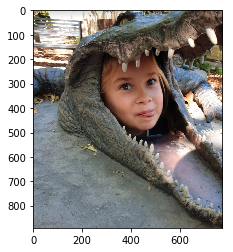

hmmm.....
You are Komondor in parallel universe



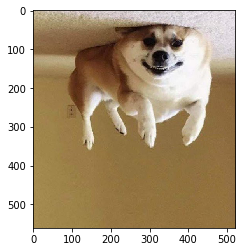

hmmm.....
Im not dog expert but it looks like...Chihuahua



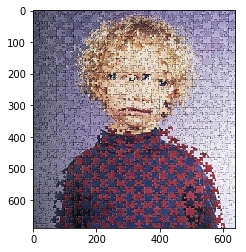

hmmm.....
I can't figure it out



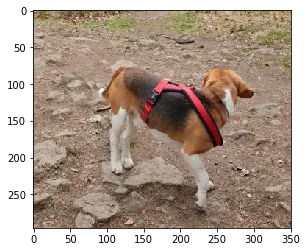

hmmm.....
Im not dog expert but it looks like...Beagle



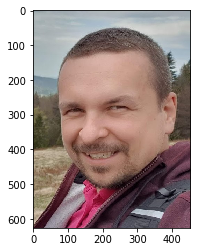

hmmm.....
You are Nova scotia duck tolling retriever in parallel universe



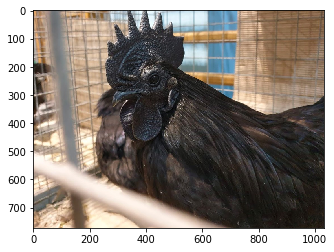

hmmm.....
You are Affenpinscher in parallel universe



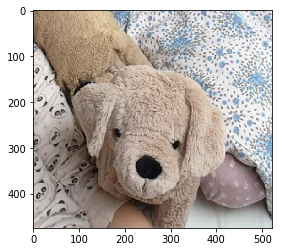

hmmm.....
I can't figure it out



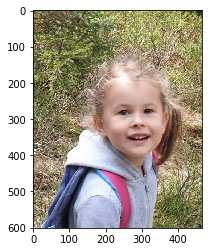

hmmm.....
You are Nova scotia duck tolling retriever in parallel universe



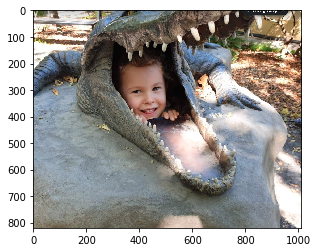

hmmm.....
You are Australian cattle dog in parallel universe



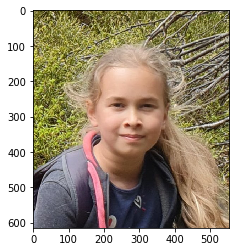

hmmm.....
You are Boykin spaniel in parallel universe



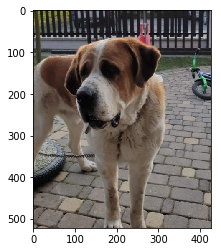

hmmm.....
Im not dog expert but it looks like...Saint bernard



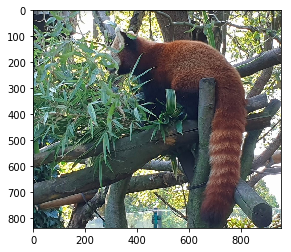

hmmm.....
I can't figure it out



In [ ]:
my_images = np.array(glob("./myimages/*"))

for file in np.hstack((my_images)):
    run_app(file)
    print()

Possible points for improvement)
1. Now app calculate output from 3 seperate models. It could be optimezed with 1 custom model that do all the work with less computation needed.
2. In case of poor quality photos app could ask for another one when it detects dog but with probality smaller than set threshold.
3. Face detector works poorly for blurry human pictures. It also detect face on image of chicken. We could benchmark face_cascade model with Facenet or similar models and swap model for face detection.